# Preparing the Data

## Imports

In [78]:
import pandas as pd
import numpy as np
import statistics as stats
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.sparse.linalg import svds

from tensorflow.keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model

## Load the Dataset

In [2]:
df = pd.read_csv('./data/combined_data_1.txt', header=None, names=['Cust_Id', 'Rating'], usecols=[0, 1])
df.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


## Cleaning the Data

In [3]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:], df_nan['index'][:-1]):
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
last_record = np.full((1, len(df) - df_nan.iloc[-1, 0] - 1), movie_id)
movie_np = np.append(movie_np, last_record)

# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print("-Dataset examples-")
print(df.iloc[::5_000_000, :])

-Dataset examples-
          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


In [4]:
f = ['count', 'mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = int(round(df_movie_summary['count'].quantile(0.7), 0))
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print(f"Movie minimum times of review: {movie_benchmark:d}")

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = int(round(df_cust_summary['count'].quantile(0.7), 0))
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print(f"Customer minimum times of review: {cust_benchmark:d}")

Movie minimum times of review: 1799
Customer minimum times of review: 52


In [5]:
print(f"Original Shape: {df.shape}")

df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print(f"After Trim Shape: {df.shape}")

print('-Data Examples-')
print(df.iloc[::5_000_000, :])

Original Shape: (24053764, 3)
After Trim Shape: (17337458, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
696        712664     5.0         3
6932490   1299309     5.0      1384
13860273   400155     3.0      2660
20766530   466962     4.0      3923


## Train-Test Split

In [6]:
i_train, i_test = train_test_split(np.array(df.index), train_size=0.8)

In [7]:
df_train = df.loc[i_train]
print(f"Train Data Shape: {df_train.shape}")
print("-Train Data Examples-")
print(df_train.iloc[::int(5_000_000 * 0.8), :])

Train Data Shape: (13869966, 3)
-Train Data Examples-
          Cust_Id  Rating  Movie_Id
15950758  2553601     4.0      3106
19380692  1208976     4.0      3684
19781036   621274     3.0      3782
9409321      7548     3.0      1861


In [8]:
df_test = df.loc[i_test]
print(f"Test Data Shape: {df_test.shape}")
print("-Test Data Examples-")
print(df_test.iloc[::int(5_000_000 * 0.2), :])

Test Data Shape: (3467492, 3)
-Test Data Examples-
          Cust_Id  Rating  Movie_Id
20760590  1349507     3.0      3921
16416402  2628206     4.0      3165
16957938   778689     1.0      3282
2283991   2066580     5.0       436


## Data Mapping

In [9]:
df_title = pd.read_csv("./data/movie_titles.csv", encoding="ISO-8859-1", header=None, names=['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
df_title.head(10)

,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
6,1997.0,Sick
7,1992.0,8 Man
8,2004.0,What the #$*! Do We Know!?
9,1991.0,Class of Nuke 'Em High 2


## Netflix Titles

In [10]:
df_netflix_titles = pd.read_csv("netflix_titles_nov_2019.csv") 
df_netflix_titles.head()

,show_id,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,type
0,81193313,Chocolate,NaN,"Ha Ji-won, Yoon Kye-sang, Jang Seung-jo, Kang ...",South Korea,"November 30, 2019",2019,TV-14,1 Season,"International TV Shows, Korean TV Shows, Roman...",Brought together by meaningful meals in the pa...,TV Show
1,81197050,Guatemala: Heart of the Mayan World,"Luis Ara, Ignacio Jaunsolo",Christian Morales,NaN,"November 30, 2019",2019,TV-G,67 min,"Documentaries, International Movies","From Sierra de las Minas to Esquipulas, explor...",Movie
2,81213894,The Zoya Factor,Abhishek Sharma,"Sonam Kapoor, Dulquer Salmaan, Sanjay Kapoor, ...",India,"November 30, 2019",2019,TV-14,135 min,"Comedies, Dramas, International Movies",A goofy copywriter unwittingly convinces the I...,Movie
3,81082007,Atlantics,Mati Diop,"Mama Sane, Amadou Mbow, Ibrahima Traore, Nicol...","France, Senegal, Belgium","November 29, 2019",2019,TV-14,106 min,"Dramas, Independent Movies, International Movies","Arranged to marry a rich man, young Ada is cru...",Movie
4,80213643,Chip and Potato,NaN,"Abigail Oliver, Andrea Libman, Briana Buckmast...","Canada, United Kingdom",NaN,2019,TV-Y,2 Seasons,Kids' TV,"Lovable pug Chip starts kindergarten, makes ne...",TV Show


## User-Movie-Matrix

In [11]:
df_p = pd.pivot_table(df, index='Cust_Id', columns='Movie_Id', values='Rating')
df_p

Movie_Id,3,8,16,17,18,26,28,30,32,33,...,4472,4474,4478,4479,4485,4488,4490,4492,4493,4496
Cust_Id,,,,,,,,,,,,,,,,,,,,,
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,5.0,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,...,3.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2649378,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2649388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,3.0,NaN,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN


In [12]:
# We use a smaller dataset to avoid memory errors
data = df_train.iloc[::2000, :]
df_p_small = pd.pivot_table(data, index='Cust_Id', columns='Movie_Id', values='Rating')
df_p_small

Movie_Id,3,8,16,17,18,26,28,30,33,44,...,4454,4465,4472,4474,4479,4488,4490,4492,4493,4496
Cust_Id,,,,,,,,,,,,,,,,,,,,,
268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2646853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2646892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2648157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Recommender Systems

## Mean Rating

In [13]:
df_title_mean = pd.DataFrame(df_train.groupby('Movie_Id')['Rating'].mean())
df_title_mean = df_title_mean.join(df_title.drop(columns='Year'))

# Normal renaming doesn't work for some reason.
df_title_mean['Mean'] = df_title_mean['Rating']
df_title_mean = df_title_mean.drop(columns=['Rating'])

df_title_mean.sort_values('Mean', ascending=False, inplace=True)

df_title_mean.head(10)

,Name,Mean
Movie_Id,,
3456,Lost: Season 1,4.661100
2102,The Simpsons: Season 6,4.588155
3444,Family Guy: Freakin' Sweet Collection,4.523465
4238,Inu-Yasha,4.462002
1476,Six Feet Under: Season 4,4.461650
1256,The Best of Friends: Vol. 4,4.445550
2452,Lord of the Rings: The Fellowship of the Ring,4.433316
1947,Gilmore Girls: Season 3,4.432909
4427,The West Wing: Season 3,4.428331


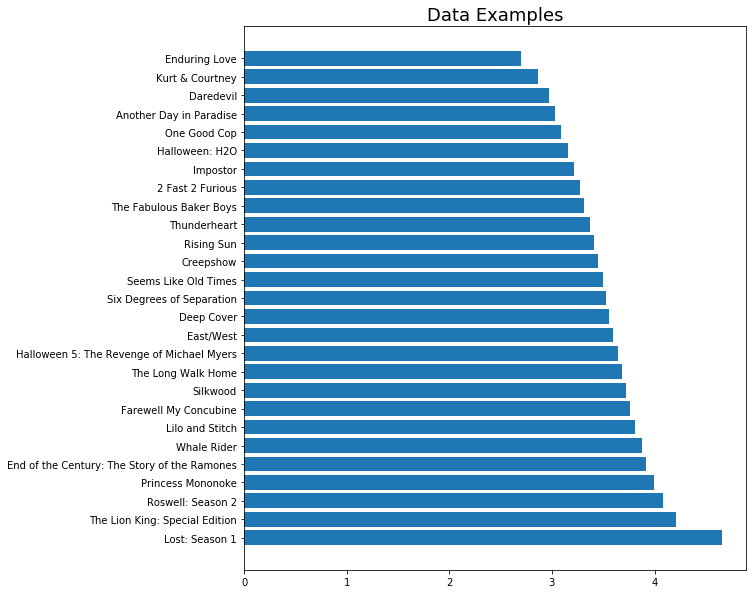

In [14]:
temp = df_title_mean.iloc[::50, :]
plt.figure(figsize=(9, 10))
plt.title("Data Examples", fontsize=18)
plt.barh(temp['Name'], temp['Mean'])
plt.show()

In [15]:
df_pred = df_test.set_index('Movie_Id').join(df_title_mean)[['Rating', 'Mean']]
rmse_mean = math.sqrt(mean_squared_error(y_true=df_pred['Rating'], y_pred=df_pred['Mean']))

print(f"RMSE: {rmse_mean:f}")

RMSE: 0.994461


## Weighted Mean Rating

The most basic way to rank movies would be their rating but such a method is too simple and fails to account for other factors, such as the popularity of a movie, thus leading to skewed and unreliable results. Therefore it is often better if our ranking is a result of combining multiple factors. Here we use IMDb's formula:
$$W = \dfrac{R v + C m}{v + m}$$
Where:
<ul>
    <li>$W$ = weighted rating</li>
    <li>$R$ = average for the movie (mean) = (rating)</li>
    <li>$v$ = number of votes for the movie = (votes)</li>
    <li>$m$ = minimum votes required to be listed in the Top Rated list</li>
    <li>$C$ = the mean vote across the whole report</li>
</ul>

In [16]:
df_movie_summary = df_train.groupby('Movie_Id')['Rating'].agg(['count', 'mean'])

m = df_movie_summary['count'].quantile(0.9)
print(f"m = {m:f}")

C = stats.mean(df_movie_summary['mean'])
print(f"C = {C:f}")

df_title_wr = df_movie_summary.drop(columns=['count', 'mean'])
df_title_wr['weighted_rating'] = (df_movie_summary['mean']*df_movie_summary['count'] + C*m)/(df_movie_summary['count'] + m)
df_title_wr = df_title_wr.join(df_title.drop(columns=['Year']))

df_title_wr.sort_values('weighted_rating', ascending=False, inplace=True)

df_title_wr.head(10)

m = 27944.800000
C = 3.485677


,weighted_rating,Name
Movie_Id,,
2452,4.193170,Lord of the Rings: The Fellowship of the Ring
3962,4.148703,Finding Nemo (Widescreen)
4306,4.104791,The Sixth Sense
2862,4.084403,The Silence of the Lambs
2782,4.051759,Braveheart
3290,4.034834,The Godfather
1905,3.995032,Pirates of the Caribbean: The Curse of the Bla...
3938,3.948087,Shrek 2
886,3.911413,Ray


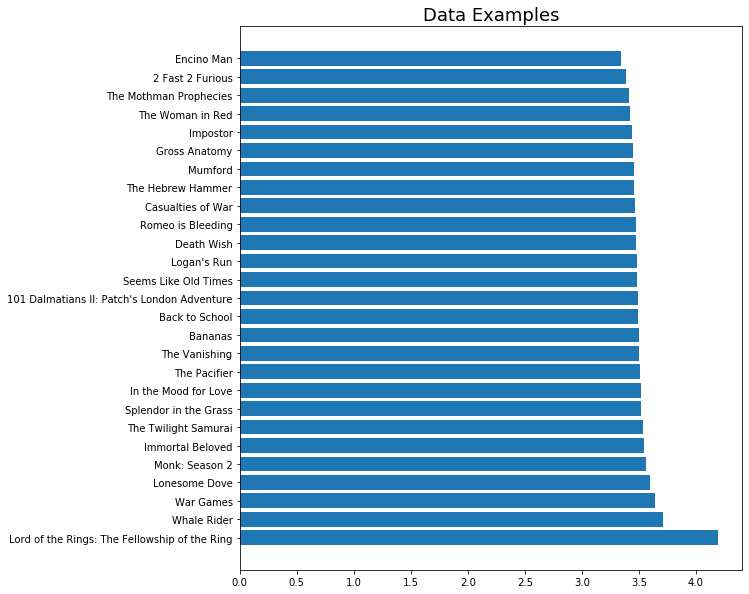

In [17]:
temp = df_title_wr.iloc[::50, :]
plt.figure(figsize=(9, 10))
plt.title("Data Examples", fontsize=18)
plt.barh(temp['Name'], temp['weighted_rating'])
plt.show()

In [18]:
df_pred = df_test.set_index('Movie_Id').join(df_title_wr)[['Rating', 'weighted_rating']]
rmse_weighted_mean = math.sqrt(mean_squared_error(y_true=df_pred['Rating'], y_pred=df_pred['weighted_rating']))

print(f"RMSE: {rmse_weighted_mean:f}")

RMSE: 1.022808


## Cosine User-User Similarity

In [72]:
# User index for recommendation
cust_index = 2_568

# Number of similar users for recommendation
n_recommendation = 100

# Plot top n recommendations
n_plot = 10

# Fill in missing values
df_p_imputed = df_p_small.T.fillna(df_p_small.mean(axis=1)).T

# Compute similarity between all users
similarity = cosine_similarity(df_p_imputed.values)

# Remove self-similarity from similarity-matrix
similarity -= np.eye(similarity.shape[0])

# Sort similar users by index
similar_cust_index = np.argsort(similarity[cust_index])[::-1]
# Sort similar users by score
similar_cust_score = np.sort(similarity[cust_index])[::-1]

# Get unrated movies
unrated_movies = df_p_small.iloc[cust_index][df_p.iloc[cust_index].isna()].index

# Weight ratings of the top n most similar users with their rating and compute the mean for each movie
mean_movie_recommendations = (df_p_imputed.iloc[similar_cust_index[:n_recommendation]].T * similar_cust_score[:n_recommendation]).T.mean(axis=0)

# Filter for unrated movies and sort results
best_movie_recommendations = mean_movie_recommendations[unrated_movies].sort_values(ascending=False).to_frame().join(df_title)


# Create user-id mapping
cust_id_mapping = {id:i for i, id in enumerate(df_p_imputed.index)}

In [73]:
prediction = []
# Iterate over all testset items
for cust_id in data['Cust_Id'].unique():
    # Sort similar users by index
    similar_cust_index = np.argsort(similarity[cust_id_mapping[cust_id]])[::-1]
    # Sort similar users by score
    similar_cust_score = np.sort(similarity[cust_id_mapping[cust_id]])[::-1]
    
    for movie_id in data[data['Cust_Id']==cust_id]['Movie_Id'].values:

        # Compute predicted score
        score = (df_p_imputed.iloc[similar_cust_index[:n_recommendation]][movie_id] * similar_cust_score[:n_recommendation]).values.sum() / similar_cust_score[:n_recommendation].sum()
        prediction.append([cust_id, movie_id, score])

In [74]:
print(f"Ranking Of Top {n_plot} Recommended Movies For A User Based On Similarity")
best_movie_recommendations.head(n_plot)

Ranking Of Top 10 Recommended Movies For A User Based On Similarity


,0,Year,Name
Movie_Id,,,
4496,3.58,1993.0,Farewell My Concubine
1395,3.58,1963.0,Charade
1561,3.58,2003.0,American Wedding
1558,3.58,1990.0,Rocky V
1553,3.58,1995.0,Persuasion
1547,3.58,1939.0,The Women
1543,3.58,1995.0,Nick of Time
1542,3.58,1993.0,Sleepless in Seattle
1532,3.58,1992.0,Mo' Money


In [75]:
# Create prediction DataFrame
df_pred = pd.DataFrame(prediction, columns=['Cust_Id', 'Movie_Id', 'Prediction']).set_index(['Cust_Id', 'Movie_Id'])
df_pred = data.set_index(['Cust_Id', 'Movie_Id']).join(df_pred)

# Get labels and predictions
y_true = df_pred['Rating'].values
y_pred = df_pred['Prediction'].values

# Compute RMSE
rmse_uu_cos = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))

print(f"RMSE: {rmse_uu_cos:f}")

RMSE: 1.076555


## Cosine Similarity

In [21]:
def my_cosine_similarity(text):
    vectorizer = CountVectorizer()
    x = vectorizer.fit_transform(text)
    
    return cosine_similarity(x)

In [22]:
#The features based on which we want to recommend movies and TV shows

features = ['title', 'director', 'cast', 'listed_in']

for feature in features:
    df_netflix_titles[feature] = df_netflix_titles[feature].fillna('') #fill the NaN values with blank strings

def combine_features(row):
    return row['title'] +" "+row['director']+" "+row['cast']+" "+row['listed_in']

df_netflix_titles["combined_features"] = df_netflix_titles.apply(combine_features, axis=1)

In [23]:
similarity = my_cosine_similarity(df_netflix_titles['combined_features'])
pd.DataFrame(similarity)

,0,1,2,3,4,5,6,7,8,9,...,5827,5828,5829,5830,5831,5832,5833,5834,5835,5836
0,1.000000,0.037662,0.027566,0.026631,0.085819,0.028072,0.029173,0.029173,0.357791,0.022244,...,0.000000,0.000000,0.000000,0.000000,0.024311,0.000000,0.000000,0.025016,0.154713,0.000000
1,0.037662,1.000000,0.146385,0.141421,0.000000,0.099381,0.154919,0.206559,0.066667,0.078750,...,0.202548,0.000000,0.052705,0.073771,0.172133,0.086066,0.062622,0.088561,0.000000,0.052705
2,0.027566,0.146385,1.000000,0.138013,0.000000,0.109109,0.151186,0.151186,0.024398,0.086459,...,0.111187,0.056980,0.038576,0.053995,0.125988,0.062994,0.045835,0.097231,0.000000,0.077152
3,0.026631,0.141421,0.138013,1.000000,0.000000,0.105409,0.255604,0.146059,0.023570,0.083527,...,0.107417,0.055048,0.037268,0.078246,0.121716,0.121716,0.088561,0.125245,0.000000,0.149071
4,0.085819,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.075955,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5832,0.000000,0.086066,0.062994,0.121716,0.000000,0.064150,0.133333,0.066667,0.000000,0.050833,...,0.098058,0.000000,0.034021,0.047619,0.055556,1.000000,0.161690,0.057166,0.000000,0.102062
5833,0.000000,0.062622,0.045835,0.088561,0.000000,0.046676,0.097014,0.048507,0.000000,0.036986,...,0.047565,0.000000,0.000000,0.069296,0.040423,0.161690,1.000000,0.041595,0.000000,0.049507
5834,0.025016,0.088561,0.097231,0.125245,0.000000,0.066010,0.137199,0.137199,0.022140,0.052307,...,0.067267,0.051709,0.035007,0.049000,0.085749,0.057166,0.041595,1.000000,0.000000,0.070014
5835,0.154713,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.136931,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000


In [24]:
def recommend_movie(movie_liked):
    index = df_netflix_titles[df_netflix_titles.title == movie_liked].index[0]
    
    movies = list(enumerate(similarity[index])) #get the row from similarity matrix 
    
    sorted_movies = sorted(movies, key = lambda movie:movie[1], reverse = True)
    sorted_movies = sorted_movies[1:11] #skip the first one because it will be the same movie the user likes and keep the first 10

    for i in range (10):
        print(df_netflix_titles[df_netflix_titles.index == sorted_movies[i][0]]['title'].values[0])

In [25]:
recommend_movie("Chip and Potato")

Pac-Man and the Ghostly Adventures
The Minimighty Kids
Super Monsters
Hatchimals | Adventures in Hatchtopia
JingleKids
Super Monsters Monster Party
My Little Pony: Friendship Is Magic
Edgar Rice Burroughs' Tarzan and Jane
The Deep
ChuChu TV Kids Songs, Learning Videos & Bedtime Stories


## Cosine TFIDF Description Similarity

In [26]:
# Create tf-idf matrix for text comparison
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_netflix_titles['description'].dropna())

# Compute cosine similarity between all movie-descriptions
similarity = cosine_similarity(tfidf_matrix)
# Remove self-similarity from matrix
similarity -= np.eye(similarity.shape[0])

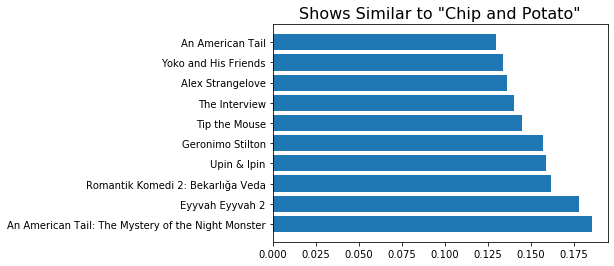

In [28]:
# Get index of movie to find similar movies
show = "Chip and Potato"
n_plot = 10
index = df_netflix_titles[df_netflix_titles.title==show].index[0]

# Get indices and scores of similar movies
similar_shows_index = np.argsort(similarity[index])[::-1][:n_plot]
similar_shows_score = np.sort(similarity[index])[::-1][:n_plot]

# Get titles of similar movies
similar_show_titles = df_netflix_titles.iloc[similar_shows_index].title

# Plot the similar show with their score.
plt.title(f"Shows Similar to \"{show}\"", fontsize=16)
plt.barh(similar_show_titles, similar_shows_score)
plt.show()

## Collaborative Filtering - SVD

In [36]:
#demeaning data
data_pivot = df_p_small.fillna(0)
R = data_pivot.values
ratings_mean = np.mean(R, axis = 1)
R = R - ratings_mean.reshape(-1,1)

In [37]:
#U: user features
#S: diagonal matrix of singular values
#V_t: movie features

U, S, V_t = svds(R, k = 60) #for movie predictions values of k between 20 and 100 have been found to be the best
S = np.diag(S)

In [38]:
predicted_ratings = np.dot(np.dot(U, S), V_t) + ratings_mean.reshape(-1, 1)
predictions = pd.DataFrame(predicted_ratings, columns = data_pivot.columns, index = data_pivot.index)
predictions

Movie_Id,3,8,16,17,18,26,28,30,33,44,...,4454,4465,4472,4474,4479,4488,4490,4492,4493,4496
Cust_Id,,,,,,,,,,,,,,,,,,,,,
268,0.004773,0.004811,0.004773,0.004775,0.004800,0.004777,0.005091,0.000543,0.004818,0.004776,...,0.004776,0.004775,0.005675,0.004773,0.004898,0.005170,0.004777,0.004777,0.004771,0.004805
1082,0.000153,-0.000222,0.000153,0.000131,-0.000117,0.000118,-0.001665,-0.000094,-0.000280,0.000122,...,0.000122,0.000135,-0.002626,0.000153,-0.000857,-0.001297,0.000113,0.000109,0.000175,-0.000164
3432,0.004767,0.004803,0.004767,0.004769,0.004792,0.004770,0.005072,0.000703,0.004809,0.004769,...,0.004769,0.004768,0.005628,0.004767,0.004886,0.005147,0.004770,0.004771,0.004765,0.004797
3458,0.000959,0.000968,0.000959,0.000960,0.000966,0.000960,0.001032,-0.000005,0.000970,0.000960,...,0.000960,0.000960,0.001170,0.000959,0.000988,0.001051,0.000960,0.000960,0.000959,0.000967
3522,0.003880,0.003924,0.003880,0.003883,0.003911,0.003884,0.004256,0.001009,0.003932,0.003884,...,0.003884,0.003882,0.005020,0.003880,0.004025,0.004365,0.003885,0.003885,0.003878,0.003917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2646853,0.004734,0.004759,0.004734,0.004736,0.004752,0.004736,0.004911,-0.002899,0.004763,0.004736,...,0.004736,0.004735,0.005151,0.004734,0.004810,0.005017,0.004737,0.004737,0.004733,0.004755
2646892,0.001124,0.000485,0.001124,0.001090,0.000681,0.001070,-0.005160,-0.001041,0.000380,0.001077,...,0.001077,0.001097,-0.021089,0.001124,-0.001093,-0.006359,0.001063,0.001056,0.001157,0.000596
2648157,0.003864,0.003904,0.003864,0.003866,0.003892,0.003867,0.004204,-0.000682,0.003910,0.003867,...,0.003867,0.003865,0.004869,0.003864,0.003996,0.004298,0.003868,0.003868,0.003861,0.003897


In [39]:
def recommend_movies(user_id, netflix_movies):
    
    sorted_preds = pd.DataFrame(predictions.loc[user_id].sort_values(ascending = False))
    user_ratings = df[df.Cust_Id == user_id]
    
    already_rated = user_ratings.merge(df_title, how='left', left_on='Movie_Id', right_on='Movie_Id')

    netflix_movies = df_title[df_title.index.isin(df['Movie_Id'])]   

    to_recommend = df_title[~df_title.index.isin(already_rated['Movie_Id'])]
    to_recommend = to_recommend.merge(sorted_preds, how='left', left_on='Movie_Id', right_on='Movie_Id')
    to_recommend = to_recommend.sort_values(by=user_id, ascending=False)
    
    for i in range(0, 10):
        print(to_recommend.iloc[i].Name)

In [41]:
recommend_movies(268, df_title)

The Family Man
Training Day
The Perfect Storm
Taking Lives
Love Actually
Eternal Sunshine of the Spotless Mind
The Others
Lock
Ever After: A Cinderella Story
Sixteen Candles


## Matrix Factorization With Keras And Gradient Descent

In [79]:
user_id_mapping = {id:i for i, id in enumerate(df['Cust_Id'].unique())}
movie_id_mapping = {id:i for i, id in enumerate(df['Movie_Id'].unique())}


# Create correctly mapped train & test datasets
train_user_data = df_train['Cust_Id'].map(user_id_mapping)
train_movie_data = df_train['Movie_Id'].map(movie_id_mapping)

test_user_data = df_test['Cust_Id'].map(user_id_mapping)
test_movie_data = df_test['Movie_Id'].map(movie_id_mapping)


# Get input variable-sizes
users = len(user_id_mapping)
movies = len(movie_id_mapping)
embedding_size = 10

In [80]:
# Set input layers
user_id_input = Input(shape=[1], name='user')
movie_id_input = Input(shape=[1], name='movie')

# Create embedding layers for users and movies
user_embedding = Embedding(output_dim=embedding_size, 
                           input_dim=users,
                           input_length=1, 
                           name='user_embedding')(user_id_input)
movie_embedding = Embedding(output_dim=embedding_size, 
                            input_dim=movies,
                            input_length=1, 
                            name='item_embedding')(movie_id_input)

In [81]:
# Reshape the embedding layers
user_vector = Reshape([embedding_size])(user_embedding)
movie_vector = Reshape([embedding_size])(movie_embedding)

In [82]:
# Compute dot-product of reshaped embedding layers as prediction
y = Dot(1, normalize=False)([user_vector, movie_vector])

In [83]:
# Setup model
model = Model(inputs=[user_id_input, movie_id_input], outputs=y)
model.compile(loss='mse', optimizer='adam')

In [84]:
# Fit model
model.fit([train_user_data, train_movie_data],
          df_train['Rating'],
          batch_size=256, 
          epochs=1,
          validation_split=0.1,
          shuffle=True)

Train on 12482969 samples, validate on 1386997 samples
12482969/12482969 [==============================] - 396s 32us/sample - loss: 2.0394 - val_loss: 0.9527


In [86]:
# Test model
y_pred = model.predict([test_user_data, test_movie_data])
y_true = df_test['Rating'].values

In [87]:
#  Compute RMSE
rmse_keras_gradient = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print(f"RMSE: {rmse_keras_gradient:f} RMSE")

RMSE: 0.977105 RMSE


## Deep Learning - Keras

In [96]:
# Setup variables
user_embedding_size = 20
movie_embedding_size = 10

In [97]:
# Set input layers
user_id_input = Input(shape=[1], name='user')
movie_id_input = Input(shape=[1], name='movie')

In [98]:
# Create embedding layers for users and movies
user_embedding = Embedding(output_dim=user_embedding_size, 
                           input_dim=users,
                           input_length=1, 
                           name='user_embedding')(user_id_input)
movie_embedding = Embedding(output_dim=movie_embedding_size, 
                            input_dim=movies,
                            input_length=1, 
                            name='item_embedding')(movie_id_input)

In [99]:
# Reshape the embedding layers
user_vector = Reshape([user_embedding_size])(user_embedding)
movie_vector = Reshape([movie_embedding_size])(movie_embedding)

In [100]:
# Concatenate the reshaped embedding layers
concat = Concatenate()([user_vector, movie_vector])

In [101]:
# Combine with dense layers
dense = Dense(256)(concat)
y = Dense(1)(dense)

In [102]:
# Setup model
model = Model(inputs=[user_id_input, movie_id_input], outputs=y)
model.compile(loss='mse', optimizer='adam')

In [103]:
# Fit model
model.fit([train_user_data, train_movie_data],
          df_train['Rating'],
          batch_size=256, 
          epochs=1,
          validation_split=0.1,
          shuffle=True)

Train on 12482969 samples, validate on 1386997 samples
12482969/12482969 [==============================] - 822s 66us/sample - loss: 0.8720 - val_loss: 0.8387


In [104]:
# Test model
y_pred = model.predict([test_user_data, test_movie_data])
y_true = df_test['Rating'].values

In [105]:
#  Compute RMSE
rmse_dl_keras = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print(f"RMSE: {rmse_dl_keras:f}")

RMSE: 0.916561


# Results

**Note:** With cosine, cosine tfidf and svd there is no RMSE to compare.

In [106]:
results = {"Mean Rating":rmse_mean,
           "Weighted Mean Rating":rmse_weighted_mean,
           "Cosine User-User Similarity":rmse_uu_cos,
           "Matrix Factorization with Keras And Gradient Descent":rmse_keras_gradient,
           "Deep Learning with Keras":rmse_dl_keras}

for engine, rmse in results.items():
    print(f"Testing Result With {engine}: {rmse:f} RMSE")

Testing Result With Mean Rating: 0.994461 RMSE
Testing Result With Weighted Mean Rating: 1.022808 RMSE
Testing Result With Cosine User-User Similarity: 1.076555 RMSE
Testing Result With Matrix Factorisation with Keras And Gradient Descent: 0.977105 RMSE
Testing Result With Deep Learning with Keras: 0.916561 RMSE
